## Introduction

In this notebook, you'll develop a simple (though not that simple) approach to electricity disaggregation from simulated smart meter data.  Electricity disaggregation is the task of taking an aggregate energy signal (such as the readings that come, once an hour, from an electricity meter at your house) and attempting to break down the end uses of this electricity: separating the signal into the components based upon cooling, heating, large appliances, lighting, etc.  Studies have shown that providing this type of detailed breakdown and let consumers or building managers make better decisions about energy management, and also provides improved consumption forecasting approaches.

In this notebook, you'll use PyMC to develop a probabilistic model that will let you compute a simple breakdown of whole-home energy into three different categories: air conditioning (we'll consider data that only spans a summer month, so there won't be any heating component), appliances (devices that are on sporadically only when an occupant is home and awake), and baseload (devices that are always on, regardless of whether the occupant is home, away, or asleep).

## Example data

Let's begin by loading our example data set, and looking at some different views of the data.  This is a synthetically generated data set (though using real temperature from the Pittsburgh area to simulate air conditioning demands), so in our example, we're going to asssume we have ground truth data (i.e., we know the breakdown over the three different categories).  We can use this to compare how well our model matches the underlying data.

First, you can load the `consumption.csv` file as shown below.  This contains simulated energy consumption for a home in Pittsburg

In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
import seaborn
# AUTOLAB_IGNORE_STOP 
import datetime
# AUTOLAB_IGNORE_START
%matplotlib inline

def multiplication():
    list = [ ]
    for i in range(3,6):
        for j in range(2):
            if i * j < 3:
                list.append(i*j)
    print list
multiplication()

[0, 0, 0]


In [2]:
df = pd.read_csv("consumption.csv", parse_dates=["Local Time", "EightHour", "Day"])
df.set_index("Local Time", inplace=True)

The total consumption of the house is contained in the "Consumption" column, as well as the breakdown by "Cooling", "Appliances", and "Baseload".  In addition to these three consumption categories, there is also an "Occupancy" indicator, that indicates whether the occupant is away (Occupacy = 0), home and asleep (Occupancy = 1) or home and awake (Occupancy = 2).  We can look at the total consumption over this period, as well as the true breakdown of energy, via the following calls.

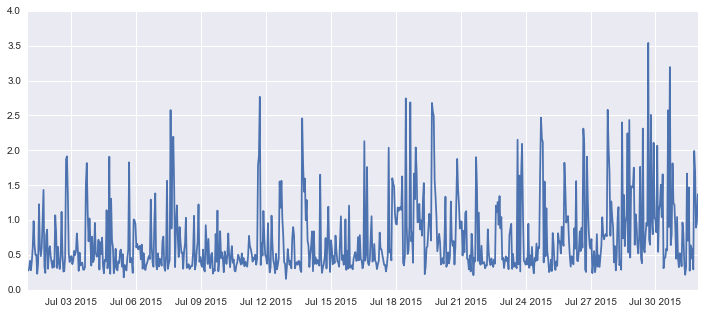

In [3]:
plt.figure(figsize=(12,5))
plt.plot(df.index.tolist(), df["Consumption"]);

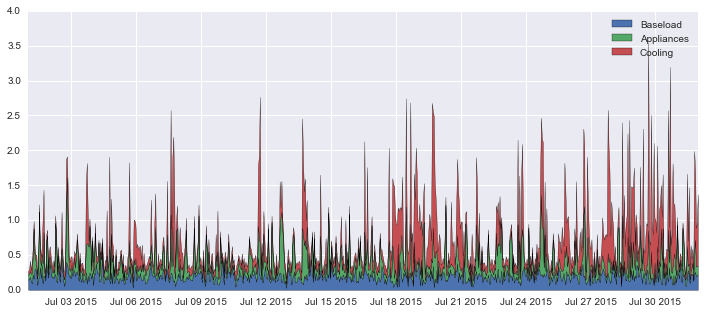

In [4]:
plt.figure(figsize=(12,5))
plt.stackplot(df.index.tolist(), df["Baseload"], df["Appliances"], df["Cooling"])
plt.legend(["Baseload", "Appliances", "Cooling"]);

In addition to these plots, there are a few other views that are helpful to consider for the data.  The first is a "average daily" view, where we can see the average consumption by time of day for each of these categories for the month of July

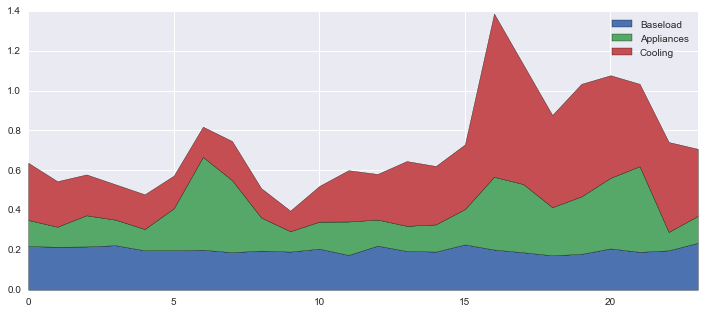

In [5]:
plt.figure(figsize=(12,5))
df0 = df.groupby("Hour").mean()
plt.stackplot(df0.index.tolist(), df0["Baseload"], df0["Appliances"], df0["Cooling"])
plt.xlim([0,23])
plt.legend(["Baseload", "Appliances", "Cooling"]);

You can also look at average occupancy during the days over the month (averaging the occupancy values doesn't make sense, since they are categorical variables, so we instead need to average a one-hot encoding of the occupancy state).

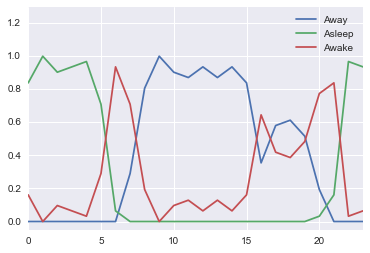

In [6]:
df["Occupancy_away"] = np.eye(3)[df["Occupancy"],0]
df["Occupancy_asleep"] = np.eye(3)[df["Occupancy"],1]
df["Occupancy_awake"] = np.eye(3)[df["Occupancy"],2]
df0 = df.groupby("Hour").mean()
plt.plot(df0.index.tolist(), df0["Occupancy_away"], 
         df0.index.tolist(), df0["Occupancy_asleep"], 
         df0.index.tolist(), df0["Occupancy_awake"])
plt.xlim([0,23])
plt.legend(["Away", "Asleep", "Awake"])
plt.ylim([-0.05,1.3]);

Finally, there is one last view that is useful to consider when looking at energy consumption.  Much as we did in class when we analyzed the total electricity consumption of Pittsburgh, we can consider the consumption of the home on the y axis plotted against the external temperature on the x axis.  We also color code the plots by the state of the occupant (away, asleep, awake).

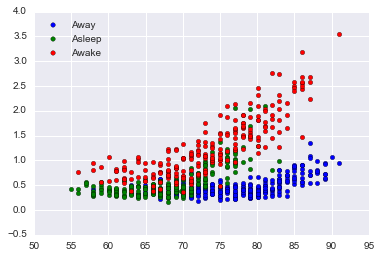

In [7]:
plt.figure()
plt.scatter(df[df["Occupancy"]==0]["Temperature"], df[df["Occupancy"]==0]["Consumption"], c='b')
plt.scatter(df[df["Occupancy"]==1]["Temperature"], df[df["Occupancy"]==1]["Consumption"], c='g')
plt.scatter(df[df["Occupancy"]==2]["Temperature"], df[df["Occupancy"]==2]["Consumption"], c='r')
plt.legend(["Away", "Asleep", "Awake"], loc="upper left")

# AUTOLAB_IGNORE_STOP 

## Q1: Generative modeling [20pts]

In this question you'll develop a generative probabilistic model to explain what drives electricity consumption in this home, and use it to produce a disaggregation of the energy into its constituent parts, using only the observed totals.  Looking at the figures above, we can hypothesize that 1) appliances seem to be used chiefly when the occupant is at the home and awake; 2) when the occupant is home, we see a linear trend of increasing consumption with repsect to temperature after the temperature reaches a certain point; and 3) we see a similar effect when the occupant is away, but with a much smaller increase.  These factors can lead us to formulate the following probabilistic model.  Because energy is always positive, we're going to use Gamma distributions to model consumption instead of a normal distribution.

More formally, the process is governed by the following generative model:
\begin{equation}
\begin{split}
\mathrm{occupancy}_t & \sim \mathrm{Categorical}(\phi^{(t\%24)}) \\
\mathrm{cooling\_\mu}_t & = \left\{ \begin{array}{ll} 
a_{\mathrm{cooling\_in}} \cdot \max\{\mathrm{temp}_t - s_{\mathrm{cooling\_in}},0 \} + b_{\mathrm{cooling\_in}} &
\mbox{ if } \mathrm{occupancy}_t \in \{1,2\} \\ 
a_{\mathrm{cooling\_out}} \cdot \max\{\mathrm{temp}_t - s_{\mathrm{cooling\_out}},0 \} + b_{\mathrm{cooling\_out}} &
\mbox{ if } \mathrm{occupancy}_t \in \{0\} 
\end{array} \right . \\
\mathrm{cooling}_t & \sim \mathrm{Gamma}(\alpha_{\mathrm{cooling}}, \alpha_{\mathrm{cooling}}/\mathrm{cooling\_\mu}_t) \\
\mathrm{appliances\_\mu}_t & = \left\{ \begin{array}{ll} 
b_{\mathrm{appliances\_on}} & \mbox{ if } \mathrm{occupancy}_t \in \{2\} \\ 
b_{\mathrm{appliances\_off}} & \mbox{ if } \mathrm{occupancy}_t \in \{0,1\}
\end{array} \right . \\
\mathrm{appliances}_t & \sim \mathrm{Gamma}(\alpha_{\mathrm{appliances}}, \alpha_{\mathrm{appliances}}/\mathrm{appliances\_\mu}_t) \\
\mathrm{baseload}_t & \sim \mathrm{Gamma}(\alpha_{\mathrm{baseload}}, 
\alpha_{\mathrm{baseload}}/\mathrm{baseload\_\mu}_t) \\
\mathrm{total}_t & \sim \mathcal{N}(\mathrm{cooling}_t + \mathrm{appliances}_t + \mathrm{baseload}_t, \tau)
\end{split}
\end{equation}

where the parameters of this model include
\begin{equation}
\begin{split}
\phi^{(0:23)} & \mbox{ - categorical occupancy probabilities for each hour} \\
a_{\mathrm{cooling\_in}} & \mbox{ - AC linear term for occupied building} \\
s_{\mathrm{cooling\_in}} & \mbox{ - AC breakpoint for occupied building} \\
b_{\mathrm{cooling\_in}} & \mbox{ - AC baseline for occupied building} \\
a_{\mathrm{cooling\_out}} & \mbox{ - AC linear term for unoccupied building} \\
s_{\mathrm{cooling\_out}} & \mbox{ - AC breakpoint for unoccupied building} \\
b_{\mathrm{cooling\_out}} & \mbox{ - AC baseline for unoccupied building} \\
\alpha_{\mathrm{cooling}} & \mbox{ - Gamma distribution $\alpha$ parameter for cooling variable} \\
b_{\mathrm{appliances\_on}} & \mbox{ - Mean of appliance consumption when they are on} \\
b_{\mathrm{appliances\_off}} & \mbox{ - Mean of appliance consumption when they are off} \\
\alpha_{\mathrm{appliances}} & \mbox{ - Gamma distribution $\alpha$ parameter for appliances variable} \\
\mathrm{baseload}\_\mu_t & \mbox{ - Mean of always on baseload} \\
\alpha_{\mathrm{baseload}} & \mbox{ - Gamma distribution $\alpha$ parameter for baseload variable} \\
\tau & \mbox{ - Precision (inverse variance) for Gaussian distribution on total energy}
\end{split}
\end{equation}

Conceptually, this model is essentially the following: we suppose that each of cooling, appliances, and baseload are governed by gamma distributions.  We effectively set the mean of each of these distributions, where for the cooling load, the mean is dictated by a rectified linear function (really two different functions, depending on whether the occupant is home or not); the appliance means is dicted by an "appliances on" mean (for which the occupant is awake), an an "appliances off" mean (when the occupany is away or asleep), and a baseload mean (which is constant regardless of the state of the occupant).  The variable we ultimately observe is the sum of these three variables, with small added random noise.

For this question, you can use the following settings for the parameters (not that for the code we use slightly different notation than above, but the mapping should be obvious).  We'll assume these values are fixed for now, and won't worry about samples from them or estimating them, just about getting the best estimated for the individual breakdowns given good settings for this parameters.

In [8]:
params = {"occupancy_P": np.array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.016,  0.331,
                                     0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,
                                     0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.184,  0.009,  0.   ,  0.   ],
                                   [ 0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.9  ,  0.701,  0.095,  0.002,
                                     0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
                                     0.   ,  0.   ,  0.   ,  0.   ,  0.016,  0.331,  0.9  ,  0.9  ],
                                   [ 0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.299,  0.889,  0.667,
                                     0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.1  ,  0.1  ,
                                     0.5  ,  0.5  ,  0.5  ,  0.5  ,  0.8  ,  0.66 ,  0.1  ,  0.1  ]]).T,
          "cooling_a_in": 0.1,
          "cooling_break_in": 70.0,
          "cooling_a_out": 0.05,
          "cooling_break_out": 80.0,
          "cooling_base": 0.1,
          "cooling_alpha": 10.0,
          
          "appliances_mean_on": 0.5,
          "appliances_mean_off": 0.1,
          "appliances_alpha": 5.0,
                    
          "baseload_mean": 0.2,
          "baseload_alpha": 5.0,
          
          "total_tau": 10.0
          }

Now you'll want to write the following function, which instantiates a set of PyMC variables based upon these parameters and the observed temperature data in `df`.  The function takes a dataframe (the `df` variable we've used so far, which we get the temperature and total consumption from, plus the above parameters dictionary, and results a dictionary of resulting variables: one for the sequences of occupancies, coolings, appliances, baseloads, and totals.

This function can be written in several ways, and we encourage you to look at the PyMC documentation (https://pymc-devs.github.io/pymc/) for more information.  Another very nice resource is the tutorial available here: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb Note that you can write this function _without_ using any of the "function decorator" notation described in the PyMC documentation (though you're always welcome to use the decorator methods if you prefer.

In [17]:

def build_disaggretation_model(df, params):
    """
    Build a generative model for use in energy disaggregation.  All the variables in the model 
    are assumed to be unobserved, except the total consumption variable _is_ required to be
    observed with the values from df.
    
    Args:
        - df (Pandas Dataframe): dataframe with total consumption and temp information
        - params (dictionary): parameter settings as created in the previous cell
        
    Returns:
        - dictionary with the keys: "occupancy", "cooling", "appliances", "baseload", "total", 
          each of which is a PyMC Container object containing a list of random variables of the 
          appropriate type.
    """
    d = {}
    d['occupancy'] = []
    d['cooling'] = []
    d['appliances'] = []
    d['baseload'] = []
    d['total'] = []
    
    
    ###################          METHOD 0
#     d['occupancy'] = pm.Container([pm.Categorical('occ_{}'.format(i), p = params['occupancy_P'][i%24,:]) for i in range(len(df))])
    

    
    ###################          METHOD 1
    
#     d['occupancy'] = pm.Container([pm.Categorical('occ_{}'.format(i), p = params['occupancy_P'][i%24,:]) for i in range(len(df))])
#     @pm.deterministic(plot=False)
#     def cooling_mean(occ = d['occupancy'][i]):
#         if occ < 1:
#             return params['cooling_a_out']*max(df['Temperature'].values[i] - params['cooling_break_out'], 0.0) + params['cooling_base']
#         else:
#             return params['cooling_a_in']*max(df['Temperature'].values[i] - params['cooling_break_in'], 0.0) + params['cooling_base']
    
#     d['cooling'] = pm.Container([pm.Gamma('cooling_{}'.format(i),params['cooling_alpha'], params['cooling_alpha']/cooling_mean) for i in range(len(df))])
    
#     @pm.deterministic(plot=False)
#     def occ_mean(occ = d['occupancy'][i]):
#         if occ >= 2:
#             return params['appliances_mean_on']
#         else:
#             return params['appliances_mean_off']    
    
#     d['appliances'] = pm.Container([pm.Gamma('appliances_{}'.format(i),params['appliances_alpha'],params['appliances_alpha']/occ_mean) for i in range(len(df))])
#     print d['appliances'][1].parents
#     d['baseload'] = pm.Container([pm.Gamma('baseload',params['baseload_alpha'], params['baseload_alpha']/params['baseload_mean']) for i in range(len(df))])
#     d['total'] = pm.Container([pm.Normal('total',d['cooling'][i]+d['appliances'][i]+d['baseload'][i],params['total_tau']) for i in range(len(df))])
#     print d['total'][1].parents
#         d['total'] = pm.Container([pm.Normal('total',df["Baseload"].values[i] + df["Appliances"].values[i] + df["Cooling"].values[i],params['total_tau']) for i in range(len(df))])

    ###################          METHOD 2
    for i in xrange(len(df)): 
        #### OCCUPANCY #####
        d['occupancy'].append(pm.Categorical('occupancy', p = params['occupancy_P'][i%24,:]))
        #####   COOLING   ################################################################   
        c_u_in = params['cooling_a_in']*max(df['Temperature'].values[i] - params['cooling_break_in'], 0.0) + params['cooling_base']
        c_u_out = params['cooling_a_out']*max(df['Temperature'].values[i] - params['cooling_break_out'], 0.0) + params['cooling_base']
        d['cooling'].append(pm.Gamma('cooling',params['cooling_alpha'],params['cooling_alpha']/(((d['occupancy'][-1] < 1)*c_u_out) + ((d['occupancy'][-1] >= 1)*c_u_in))))
        ##### APPLIANCES #################################################################
        app_u_awk = params['appliances_mean_on']
        app_u = params['appliances_mean_off']
        d['appliances'].append(pm.Gamma('appliances',params['appliances_alpha'],params['appliances_alpha']/(((d['occupancy'][-1] < 2)*app_u) + ((d['occupancy'][-1]  >= 2)*app_u_awk))))
        ##### BASELOAD ####################################################################
        d['baseload'].append(pm.Gamma('baseload',params['baseload_alpha'], params['baseload_alpha']/params['baseload_mean']))
        ##### TOTAL #######################################################################
        d['total'].append(pm.Normal('total',df["Baseload"].values[i] + df["Appliances"].values[i] + df["Cooling"].values[i],params['total_tau'], observed = True, value = df["Baseload"].values[i] + df["Appliances"].values[i] + df["Cooling"].values[i]))
    
    d['occupancy'] = pm.Container(d['occupancy'])
    d['cooling'] = pm.Container(d['cooling'])
    d['appliances'] = pm.Container(d['appliances'])
    d['baseload'] = pm.Container(d['baseload'])
    d['total'] = pm.Container(d['total'])
    return d

# @pymc.deterministic(plot=False)
# def appliance_mean(occ =..., on=..., of=...):
#     if cond:
#         return something
#     else:
#         return the other thing
# new_gamma_var = pymc.Gamma(name = ..., 
#                                    alpha = ..., beta = .../appliance_mean))
 
    

You can test your code via the following test case.  This will construct a PyMC model from the data, set all their variable (even the unobserved ones) to their true values, and compute the log likelihood.  If your model is correct, you will get the exact same number we do.  Specifically, you should should output the likelihood: `2677.66856106`

In [18]:
### AUTOLAB_IGNORE_START
variables = build_disaggretation_model(df, params)
model = pm.Model(variables.values())

In [19]:
for i in range(len(df)):
    variables["occupancy"][i].value = df["Occupancy"].iloc[i]
    variables["cooling"][i].value = df["Cooling"].iloc[i]
    variables["appliances"][i].value = df["Appliances"].iloc[i]
    variables["baseload"][i].value = df["Baseload"].iloc[i]
print model.logp
### AUTOLAB_IGNORE_STOP

2677.66856106


While you just need to specify the correct model to get full credit for the autolab submission, you should also try running your model to see how well you recover the underlying signals.  You can do this by running MCMC.  After running, you can take a look at the last sample (i.e., just the values of the varialbles) to get a sense of how well it matches the posterior.  Note that since this is only comparing a single sample, we wouldn't expect the data to match exactly, but are just looking for a reasonably close fit.

In [12]:
### AUTOLAB_IGNORE_START
mcmc = pm.MCMC(model, db="pickle")
mcmc.sample(100, burn=10)

ValueError: A tallyable PyMC object called total already exists. This will cause problems for some database backends.

In [ ]:
est_cooling = np.array([variables["cooling"][i].value for i in range(len(df))])
plt.figure(figsize=(12,5))
plt.plot(df.index.tolist(), df["Cooling"], df.index.tolist(), est_cooling);
plt.legend(["True cooling", "Estimated cooling"]);
### AUTOLAB_IGNORE_STOP

## Q2: Bayesian modeling [13pts]

One less-than-satisfying aspect to the above model is that we needed to explicty specify the fairly long list of parameters.  Had we grossly mis-estimated one of the parameters, our method produces meaningless breakdowns.  However, because these parameters can very from house to house: for instance, because the breakpoint for where the AC starts running and the linear coefficient on the AC both will be differnt for different homes (both due to differnt systems and different occupant behavior), we want to be able to estimates parameters like these from the data.  In theory we can and should put priors and hyperparameters over just about every parameters in our model, but for now we'll consider estimating a few of them.  Specifically, we will consider a Bayesian procedure, where we make the following parameters:

    "cooling_a_in"
    "cooling_break_in"
    "cooling_a_out"
    "cooling_break_out"
    "cooling_base"
    "appliances_mean_on"
    "appliances_mean_off"
    "baseload_mean"
    
all themselves be random variables.  The rest of the values in `params` remain unchanged.  The prior distribution for all of these variables is an $\mathrm{Exponential}(\lambda)$ distribution with $\lambda = 1.0$ except for the two breakpoint parameters (`"cooling_break_in"` and `"cooling_break_out"`) which are $\mathrm{Uniform}(60,90)$.  These are covered by the following hyperparameter dictionary.

In [ ]:
hyperparams = {"cooling_break_uniform": [60,90],
               "mean_exponential": 1.0}

For this questions, you'll want to implement the following function.  The signature is similar to the `build_disaggregation_model` function above, except that the function takes a dictionary of hyperparameters as well.  First create a copy of `params` that is identical except with the parameter constrained replaced by PyMC random variables for the variables mentioned above.  Then pass this to the old `build_disaggregation_model` to create the variables (if you write the old function correctly, you won't have to change it at all when passing a `params` dictionary that contains some random variables in addition to the previous constants.  Then return both the resulting variables dictionary and the new params dictionary.

In [ ]:
def build_bayesian_disaggretation_model(df, params, hyperparams):
    """
    Build a generative model for use in energy disaggregation.  All the variables in the model 
    are assumed to be unobserved, except the total consumption variable _is_ required to be
    observed with the values from df.
    
    Args:
        - df (Pandas Dataframe): dataframe with total consumption and temp information
        - params (dictionary): parameter settings as in the previous function
        - hyperparams (dictionary): hyperparameter settings as in the previous cell
        
    Returns: tuple (variables, bayes_params)
        - variables: dictionary with the same keys as in the build_disaggregation_model
        - bayes_params: dictionary with the same keys as params, but only for random variables parameters
    """

After running this function, you can check to see if you're building the correct models by comparing the log-likelihood on the observed data.  The following code should output the likelihood: `2669.8161663`

In [ ]:
### AUTOLAB_IGNORE_START
variables, bayes_params = build_bayesian_disaggretation_model(df, params, hyperparams)
model = pm.Model([variables.values(), bayes_params.values()])

for i in range(len(df)):
    variables["occupancy"][i].value = df["Occupancy"].iloc[i]
    variables["cooling"][i].value = df["Cooling"].iloc[i]
    variables["appliances"][i].value = df["Appliances"].iloc[i]
    variables["baseload"][i].value = df["Baseload"].iloc[i]
    
for k,v in params.iteritems():
    if type(bayes_params[k]) != type(v):
        bayes_params[k].value = v
    
print model.logp
### AUTOLAB_IGNORE_STOP

## Q2+: Analysis
This part of the question will not have any graded component, but you should try to do some MCMC sampling within the Bayesian model to see if you can recover the different energy components even _without_ knowing the house parameters beforehand.  As a word of warning, due to an issue with how this version of PyMC constructs its sampler, this can be a very memory-intensive process, so you may want to explore the `db=` option for the `pm.MCMC` class if you run out of RAM.  You also need to run for substantially more iterations (we found we need about 1000), and you need reasonable initialization for the `cooling_break_*` variables (both set to 75 at the start of MCMC seemed to work well).  But with these settings you can indeed get a good breakdown of energy for this partiular simulated environment, it just takes a bit of time.  Overall these models start to get a little bit challenging, but try to play around for a bit.  Plot the from section Q0 with the MCMC data to see how well all of these components compare to the ground truth.